In [1]:
# Environment Setup
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# Shaping Input Signals

These notes are an extension of the [Input Shaping Tutorial](http://code.eng.buffalo.edu/tdf/papers/acc_tut.pdf) paper. I'd recommend starting with the first four pages (up through section 2.2) first and reading on for implemention tricks that apply to CNC gantry kinematics.

The idea behind input shaping goes back to modeling a system as a second order damped harmonic oscillator. These systems oscillate in a decaying fashion in response to an impulse.

These have a resonant natural frequency at $w_n$. If we plot the system's response to an impulse, we get damped harmonic oscillation over a period of time.

In [2]:
# TODO: impulse response graph

Knowing that the response creates a damped oscillatory output, we can actually follow up our initial impulse response with a second impulse at a particular time and amplitude to completely cancel the system's oscillatory response.

In [3]:
# TODO: cancelling oscillations

Rather than send impulses though, it would make more sense to send control signals that last for a finite amount of time. To do this, we simply take any desired input signal and convolve it with our two impulses above.

# From Impulse Control to Position Control
So here's the big question: for a position-controlled stepper motor, what's the control input we actually want to convolve?

Let's take a step back for a second and ask ourselves: what is an impulse? As it's being applied above, it's a force applied for an infinitesimal amount of time. This checks out with the [classical definition of an impulse](https://en.wikipedia.org/wiki/Impulse_(physics)), which is the integral of force over a time interval.

But stepper motors are position-controlled, so how do we control it with force?

Well, since $F = ma$, we 

Best guess: Acceleration. Since we control position, velocity, and acceleration, and since $F = ma$, it might make sense to convolve the input signal that is actually causing the system to move from rest. This also makes sense intuitively since we can't instantaneously change position.

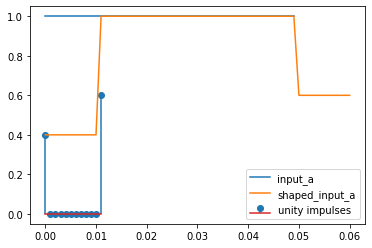

In [4]:
# Params:
w_n = 40 # Hz
impulse_amplitudes = [0.4, 0.6] # Amplitudes of the two impulses. these should sum to 1.

t_initial = 0
t_final = 0.05
t_step = 0.001

t = np.arange(t_initial, t_final, t_step)
input_a = np.ones(len(t))
impulse_times = [0, 1.0/(2 * w_n)] # Second pulse is at the half period 
unity_impulses = np.zeros(round(1.0/(2 * w_n)/t_step))
unity_impulses[0] = impulse_amplitudes[0]
unity_impulses[-1] = impulse_amplitudes[1]

# Create the shaped input signal by convolving with impulses
shaped_input_a = np.convolve(input_a, unity_impulses)

plt.plot(t, input_a, label = "input_a")
plt.stem(t[:len(unity_impulses)], unity_impulses, label = "unity impulses")
# Note: convolving the input signal returns a longer signal, so we need a new time array for it.
plt.plot(np.arange(t_initial, len(shaped_input_a)*t_step, t_step), shaped_input_a, label = "shaped_input_a")
plt.legend()
plt.show()

# Convolution Refresher and Speedups
The above signal uses numpy's built-in convolution signal, which basically does this:
$$(f * g)[n] = \sum_{k = -\infty}^{\infty}f[k]g[n-k]$$
Convolution is an $O(n^2)$ operation since every $f[k]$ needs to multiply across the whole signal $g[n]$ time shifted by $k$, i.e: $g[n-k]$.

But when when one of the two signals we're convolving is an impulse, the math gets simpler.

Suppose $f[n] = \delta [n]$, i.e:
$$f[n] =
\begin{cases} 
      1 & n = 0 \\
      0 & n \neq 0 
\end{cases}
$$
Then convolution with any function $g[n]$ just gives you $g[n]$ back like this:
$$
(f * g)[n] = f[0]g[n] = 1*g[n] = g[n]
$$

Now suppose $f[n]$ is actually a series of k impulses, each with their own corresponding magnitude and index, i.e:
$$
f[n] = 
\begin{cases} 
      f_0 & n = n_0 \\
      f_1 & n = n_1 \\
      ... \\
      f_k & n = n_k\\
      0 & n \notin \{n_0, n_1, ..., n_k \}
\end{cases}
$$
Then the convolution with $g[n]$ is just a summation of $k$ terms like this:
$$
(f * g)[n] = 
\sum_{k = 0}^{n} f_k g[n - n_k]
$$
the equation above is a bit wonky, but keep in mind that $(n_0, f_0)$, $(n_1, f_1)$, ... are impulse magnitudes happening at index $n_i$.

This might make more sense in the time domain:
$$(f * g)(t) = \sum_{k = 0}^{n} f(t_k) g(t - t_k)$$
Note that since our function $f(t)$ is not continuous over any region, we don't need to do an integration; we simply sum up their discrete defined points.

The effects of this reduction is pretty big! If we want to know the result of the convolution at time $t_i$, we just need to sum n multiplications. 

If $t_i = 0$, we get:
$$(f * g)(0) = \sum_{k = 0}^{n} f(t_k) g(-t_k)$$

Knowing how convolution of any function with a series of impulses makes the math simpler lets us define a new convolution equation.

In [5]:
def impulse_sequence_conv(impulse_indices, impulse_magnitudes, g):
    """return the result of convolution between a sequence of impulses and g[n].
    Input:
        impulse_indices: list of indices indicating the index of the ith pulse in f[n]
            i.e: such that f[impulse_indices[i]] = impulse_magnitude[i]
        impulse_magnitudes: list of all nonzero pulse magnitudes in f[n]
        g: list consisting of g[n], the second signal to convolve with.
    """
    
    assert len(impulse_indices) == len(impulse_magnitudes)
    
    # f has been compressed since the zeros betweeen pulses are not present.
    len_f = impulse_indices[-1] - impulse_indices[0] + 1
    
    # Create storage container for resulting length of convoluted signal.
    f_conv_g = np.zeros(len_f + len(g) - 1)
    
    # Do the convolution for every data pt.
    for n in range(len(f_conv_g)):
        result = 0
        for k, f_k in zip(impulse_indices, impulse_magnitudes):
            try:
                if n - k < 0 or n - k > len(g) - 1:
                    continue
                #print(f"n - k = {n-k}, ", end="")
                result += f_k * g[n - k]
                #print(f"+= {f_k * g[n-k]}")
            except IndexError as e:
                print(e)
        f_conv_g[n] = result
    return f_conv_g


# tests
impulse_indices = [0, 2]
impulse_magnitudes = [0.4, 0.6] # These should sum to 1.
g = np.ones(10)

# Reconstruct f for printing purposes
f = np.zeros(impulse_indices[-1] - impulse_indices[0] + 1)
for index, pulse_index in enumerate(impulse_indices):
    f[pulse_index] = impulse_magnitudes[index]
    
print(f"f:   {f}")
print(f"g:   {g}")
print(f"f*g: {impulse_sequence_conv(impulse_indices, impulse_magnitudes, g)}")

f:   [0.4 0.  0.6]
g:   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
f*g: [0.4 0.4 1.  1.  1.  1.  1.  1.  1.  1.  0.6 0.6]


For our motion system, acceleration is constant. After we apply input shaping, however, it will appear as some sort of piecewise function.

# Convolution Alternatives

Since we're working with position as a function of time, it would be handy if we didn't have to work backwards from acceleration.

Suppose our impulse sequence is $f(t)$, and position, velocity, and acceleration are $x(t)$, $v(t)$, and $a(t)$ respectively.

As presented above, we'd have to (1) convolve our pulse sequence with acceleration and then compute the resulting position using the shaped acceleration. But, because of [a handy convolution property](https://en.wikipedia.org/wiki/Convolution#Integration):
$$
\int_{-\infty}^{t} (f * a)(\tau) d\tau = f * \int_{-\infty}^{t} a(\tau) d\tau
$$
Then we can actually do this:
$$
(f * x)(t) = f * \int_{-\infty}^{t} \int_{-\infty}^{\tau_2} a(\tau_1) d\tau_1 d\tau_2
$$

What that means is that we don't need to start from convolved acceleration and work up to convolved position. We can convolve position directly! This might make the math easier in certain situations where nominal position at some point in time has already been computed.

Let's prove this to ourselves by convolving our impulse sequence with acceleration signal and plotting the resulting position with convolving our impulse sequence with the position signal directly and leaving acceleration untouched.

But first, an aside...

# Classic Kinematics on a "Move"
We'll define a "move" as a starting position, stopping position, entering velocity, cruise velocity, and exiting velocity. Acceleration is a constant that's either positive, zero, or negative depending on where we are in the move.

If our starting and stopping velocities are zero, here's what our move might look like.

final x position: 2.000


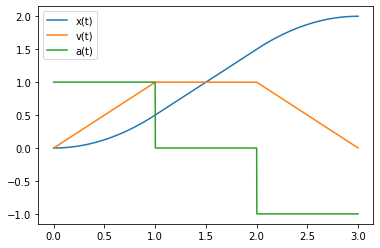

In [6]:
# Classic Kinematics Refresher with constant acceleration

t_initial = 0
t_final = 3
t_step = 0.001

t = sp.symbols('t')
accel = 1
initial_velocity = 0
initial_position = 0

a_of_t = sp.Piecewise((0, t < 0), 
                      (accel, t <= t_final/3), 
                      (0, t <= 2*(t_final/3)), 
                      (-accel, t <= t_final), 
                      (0, True))
v_of_t = sp.integrate(a_of_t, (t, 0, t)) + initial_velocity
x_of_t = sp.integrate(v_of_t) + initial_position

# Make kinematics funcs callable
a_func = sp.lambdify(t, a_of_t)
v_func = sp.lambdify(t, v_of_t)
x_func = sp.lambdify(t, x_of_t)

time_series = np.arange(t_initial, t_final, t_step)

a_series = [a_func(t) for t in time_series]
v_series = [v_func(t) for t in time_series]
x_series = [x_func(t) for t in time_series]

plt.plot(time_series, x_series, label = "x(t)")
plt.plot(time_series, v_series, label = "v(t)")
plt.plot(time_series, a_series, label = "a(t)")
plt.legend()
print(f"final x position: {x_series[-1] :.3f}")


Now let's take the above signal and convolve our impulse sequence with the acceleration signal from above.

final x position: 1.987


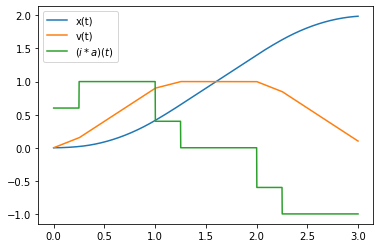

In [7]:
# This cell takes a sec to evaluate.
w_n = 2 # Hz
impulse_amplitudes = [0.6, 0.4] # Amplitudes of the two impulses. these should sum to 1.
impulse_times = [0, 1.0/(2 * w_n)] # Second pulse is at the half period 
unity_impulses = np.zeros(round(1.0/(2 * w_n)/t_step))
unity_impulses[0] = impulse_amplitudes[0]
unity_impulses[-1] = impulse_amplitudes[1]

# Convolve impulse sequence with our piecewise function using our "fast convolution" method.
i_conv_a_of_t = impulse_amplitudes[0]*a_of_t.subs(t, t - impulse_times[0]) + \
                impulse_amplitudes[1]*a_of_t.subs(t, t - impulse_times[1])
v_of_t = sp.integrate(i_conv_a_of_t, (t, 0, t)) + initial_velocity
x_of_t = sp.integrate(v_of_t) + initial_position # this line takes a while.

i_conv_a_func = sp.lambdify(t, i_conv_a_of_t)
v_func = sp.lambdify(t, v_of_t)
x_func = sp.lambdify(t, x_of_t)

i_conv_a_series = [i_conv_a_func(t) for t in time_series]
v_series = [v_func(t) for t in time_series]
x_series = [x_func(t) for t in time_series]

plt.plot(time_series, x_series, label = "x(t)")
plt.plot(time_series, v_series, label = "v(t)")
plt.plot(time_series, i_conv_a_series, label = "$(i*a)(t)$")
plt.legend()
print(f"final x position: {x_series[-1]:.3f}")
plt.show()

Let's make two observations.

First, note that nonzero acceleration values are no longer a constant magnitude. $a(t)$ is now a more complicated piecewise function. This means that the [classic "constant acceleration" formulas](https://www.khanacademy.org/science/physics/one-dimensional-motion/kinematic-formulas/a/what-are-the-kinematic-formulas) for computing position no longer hold. To extract position accurately, we must integrate.

Next, note that the two positions don't necessarily end up in the same place after the same amount of time. The position resulting from the integrated convoluted acceleration signal still has extra distance to go before it reaches the same spot as the simulation with the constant acceleration. (There **might** (?) be a way to fix this so that moves don't get stretched out over more time(?), but since our natural frequencies are on the orders of 20-100hz, we're not really adding much time here.)

# comparing x(t) generated in many ways

Now lets compare (1) the original $x(t)$ signal, (2) the $\int \int(i * a)(t)$ signal, and (3) the $(i * x)(t)$ signal.

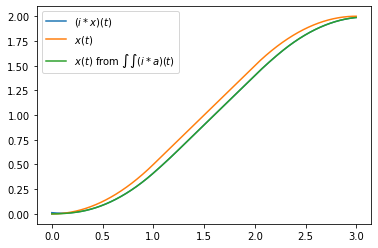

In [8]:
# Convolve impulse sequence with position signal.

# Position as a 
# some helper constants
x_at_one_third_time = initial_position + initial_velocity * (t_final/3 - t_initial) + sp.Rational(1, 2)*accel*(t_final/3 - t_initial)**2
v_at_one_third_time = accel*(t_final/3 - t_initial) + initial_velocity
x_at_two_third_time = x_at_one_third_time + v_at_one_third_time*(2*t_final/3 - t_final/3)
v_at_two_third_time = v_at_one_third_time
x_of_t_const_a = sp.Piecewise(
    (initial_position + initial_velocity * t + sp.Rational(1, 2)*accel*t**2,
         t < t_final/3),
    (x_at_one_third_time + v_at_one_third_time*(t - t_final/3),
         t < (2*t_final/3)),
    (x_at_two_third_time + v_at_two_third_time * (t - 2*t_final/3) + sp.Rational(1, 2)*-accel*(t - 2*t_final/3)**2,
         True))


# Convolve impulse sequence with our piecewise function using our "fast convolution" method.
i_conv_x_of_t = impulse_amplitudes[0]*x_of_t_const_a.subs(t, t - impulse_times[0]) + \
                impulse_amplitudes[1]*x_of_t_const_a.subs(t, t - impulse_times[1])

x_func_const_a = sp.lambdify(t, x_of_t_const_a)
i_conv_x_func = sp.lambdify(t, i_conv_x_of_t)
i_conv_x_series = [i_conv_x_func(t) for t in time_series]
x_series_const_a = [x_func_const_a(t) for t in time_series]


plt.plot(time_series, i_conv_x_series, label = "$(i*x)(t)$")
plt.plot(time_series, x_series_const_a, label = "$x(t)$")
plt.plot(time_series, x_series, label="$x(t)$ from $\int \int (i * a)(t)$")

plt.legend()
plt.show()

The above results show that $\int \int (i*a)(t)$ is equivalent to $(i*x)(t)$. It also shows how the convolved signal differs in shape from the original signal $x(t)$ with constant acceleration. Given the equivalence, we can convolve whatever signal is more convenient for us and the results will be the same--nifty!

# Making Use of the Findings

The above writeup shows us that we can basically use our original "constant acceleration" functions and simply convolve the original $x(t)$ with our impulse sequence $i(t)$ to get a new position function, $x_s(t)$, which has been "shaped" to reduce ringing.

To make use of this function, $x_s(t)$, we would actually want to compute the inverse, $x_s^{-1}(t)$. That is to say, since our stepper motor can only step a fixed amount, which sends us through a fixed distance in our "move" sequence, we want to calculate the wait time until the next step. Unfortunately, getting an analytical solution to $x_s^{-1}(t)$ is hard. That's because even though we can compute $x(t)$ analytically, convolving $x(t)$ with our impulse sequence $i(t)$ means we actually have to compute this inverse:  $x_s^{-1}(t) = \left( i(t) * x(t) \right)^{-1}$.

So the alternative would be to compute $t$ using an iterative solver like Newton's Method. This solver requires only that we know $x_s(t)$ and $v_s(t)$ for any time $t$, which we do. It then uses these values to step towards some $t_i$ for a specified input $x_i$.

In short, we cannot easily compute $x_s^{-1}(t)$ analytically. So the next easiest way to compute it would be to get a really good approximation with an iterative solver.

# Input Shaping in Multiple Dimensions

Educated guess here...

Since X and Y motion are orthogonal to each other, we should be able to calculate two natural frequencies (from pure X and pure Y motion) and then apply a unique correction for X and Y. The result will be a vector sum that cancels out linear combinations of vibrations in any XY direction. 

In [54]:
class Move(object):
    """A line segment move.
    A single move is given entry/exit velocitys and planned with a profile to:
        1. Accelerate from entry velocity up to the cruise velocity
        2. Cruise
        3. Decelerate to the exit velocity
    
    Note: velocities will never exceed the cruise velocity.
    Note: all time calculations below are done relative to this move only. 
        i.e: this move starts at t=0
    """
    v_cruise = 10.0 # mm/sec
    accel = 5.0 # mm/(sec^2)
    
    def __init__(self, v_initial, v_final, start_pos, end_pos, constant_velocity=False):
        """init
        param constant_velocity: a flag telling us to hold velocity constant throughout the entire move.
            v_initial and v_final must also be the same.
        """
        assert all(((v_initial <= self.v_cruise), 
                    (v_final <= self.v_cruise))), \
                   "Error: desired move velocities exceed the cruise velocity!"
        self.v_initial = v_initial # entry velocity
        self.v_final = v_final # exit velocity
        self.positions = (start_pos, end_pos)
        self.constant_velocity = constant_velocity
        
        self.move_distance = np.sqrt((self.positions[0][0]  - self.positions[1][0])**2 +
                            (self.positions[0][1] - self.positions[1][1])**2)
        self.t_move_end = None
        self.t_cruise_start = None
        self.t_cruise_end = None
        self.v_max = None
        self._compute_move_profile_times()
        
    def _compute_move_profile_times(self):
        """Compute the times where velocity is increasing, constant, and decreasing.
        i.e: self.t_cruise_start, self.t_cruise_end, self.t_move_end
        """
        # Case 1: 1 region. Velocity constant throughout.
        if self.constant_velocity and np.allclose(self.v_initial, self.v_final):
            self.t_move_end = self.move_distances/self.v_cruise
            self.t_cruise_start = 0
            self.t_cruise_end = self.move_distance / self.v_cruise
            self.v_max = self.v_cruise
            return
        
        # line intersect v_accel(t) with v_cruise(t) and v_cruise(t) with v_decel(t).
        accel_region_distance = (self.v_cruise**2 - self.v_initial**2)/(2*self.accel)
        decel_region_distance = (self.v_cruise**2 - self.v_final**2)/(2*self.accel)
        # Case 2: 2 regions. No cruise region. accel/decel_region_distances above are invalid 
        if (accel_region_distance + decel_region_distance) >= self.move_distance:
            self.no_cruise_region = True
            # (v_max, t_max) intersection point comes from solving system of eqns from
            # (1) increasing velocity eqn, (2) decreasing velocity eqn, (3) total distance traveled eqn.
            # Once we have v_max, t_max can be computed by plugging in v_max elsewhere.
            self.v_max = np.sqrt(4 * self.accel * self.move_distance + 2*self.v_final**2 + 2*self.v_initial**2)/2
            t_max = (self.v_max - self.v_initial)/self.accel
            self.t_cruise_start = t_max # Set such that later eqns resolve nicely.
            self.t_cruise_end = t_max
            accel_region_distance = (self.v_max + self.v_initial)/2*self.t_cruise_start
            decel_region_distance = self.move_distance - accel_region_distance
            self.t_move_end = t_max - (self.v_final - self.v_max)/self.accel # minus since a is negative
            return
        
        # General: 3 distinct regions. Accelerating, Cruising, Decelerating
        cruise_distance = self.move_distance - accel_region_distance - decel_region_distance
        self.t_cruise_start = (self.v_cruise - self.v_initial)/self.accel
        print(f"t_cruise_start: {self.t_cruise_start}")
        self.t_cruise_end = self.t_cruise_start + cruise_distance/self.v_cruise
        print(f"t_cruise_end: {self.t_cruise_end}")
        decel_interval = -(self.v_final - self.v_cruise)/self.accel
        self.t_move_end = self.t_cruise_end + decel_interval
        self.v_max = self.v_cruise
        return
    

    def get_position(self, t, ignore_bounds=False):
        """Return the position in the move as a function of time"""
        if (not ignore_bounds) and (t > self.t_move_end or t < 0):
            raise IndexError(f"position at time {t} is out of bounds.")
            
        # General Case: 3 veloctiy profiles
        # 1st Region case
        if t < self.t_cruise_start:
            return self.v_initial*t + 0.5*self.accel*t**2

        # 2nd Region case. Should not evaluate if no cruise region.
        if t < self.t_cruise_end:
            return (self.v_max**2 - self.v_initial**2)/(2*self.accel) + \
                (t - self.t_cruise_start)*self.v_max

        # 3rd Region case
        position = 0
        position += (self.v_max**2 - self.v_initial**2)/(2*self.accel)
        position += self.v_max*(self.t_cruise_end - self.t_cruise_start) # 0 if no cruise region.
        delta_t = (t - self.t_cruise_end)
        position += self.v_max*delta_t - 0.5*self.accel*delta_t**2
        return position
    
    def get_velocity(self, t, ignore_bounds = False):
        """Return the velocity at time t"""
        if (not ignore_bounds) and (t > self.t_move_end or t < 0):
            raise IndexError(f"velocity at time {t} is out of bounds.")
            
        # General Case: 3 veloctiy profiles
        # 1st Region case
        if t < self.t_cruise_start:
            return self.v_initial + self.accel*t

        # 2nd Region case. Should not evaluate if no cruise region.
        if t < self.t_cruise_end:
            return self.v_max

        # 3rd Region case
        return self.v_max - self.accel*(t - self.t_cruise_end)
    
    def get_acceleration(self, t, ignore_bounds = False):
        """Return the acceleration at time t"""
        if (not ignore_bounds) and (t > self.t_move_end or t < 0):
            raise IndexError(f"acceleration at time {t} is out of bounds.")
            
        # General Case: 3 veloctiy profiles
        # 1st Region case
        if t < self.t_cruise_start:
            return self.accel

        # 2nd Region case. Should not evaluate if no cruise region.
        if t < self.t_cruise_end:
            return 0

        # 3rd Region case
        return -self.accel
    
    def get_time_at_pos(self, x):
        """compute t = x^(-1)(x) directly to retrieve the time for a given position"""
        # TODO: compute these up-front.
        cruise_region_start = self.get_position(self.t_cruise_start)
        cruise_region_end = self.get_position(self.t_cruise_end)
        
        if x < cruise_region_start:
            return 0 # TODO: compute. Choose root.
        if x < cruise_region_end:
            return 0 # TODO: compute
        # Default:
            return 0 # TODO: compute. Choose root.
            
    
    def get_time_at_pos_newton(self, x, t_i=None):
        """for a given x location and initial time guess t_i, computes inverse function to approximate the time
            at which we reach the desired position."""
        epsilon = 1e-7 # 100 nanoseconds

        # division-by-zero checks: any case where v(t) could equal zero.
        # Since we specify entry and exit velocities >= 0, check their corresponding positions.
        if np.allclose(x, 0):
            return 0

        if np.allclose(x, self.move_distance):
            print("close to end of move. Exiting.")
            return self.t_move_end

        # Make a valid non-zero guess.
        # Weight the guess closer to the beginning of the time range
        # since we usually call this function without a guess near t=0.
        if t_i == None:
            t_i = 0.1*self.move_distance/self.v_max
            print(f"seed guess: {t_i}")
            
        # We can't guess t_i = 0 or the iterative solver denominator blows up.            
        if np.allclose(t_i, 0):
            t_i = 10*epsilon
            print("avoid divide by zero snafu")
        
        # General case: successivly better Taylor Approximations via Newton's Method
        error = np.inf
        epsilon = 1e-7
        iterations = 0
        while abs(error) > epsilon:
            iterations+=1
            # t_{i+1} = t_i + (x - x(t_i))/x'(t_i)
            t_new = t_i + (x - self.get_position(t_i, ignore_bounds=True))/\
                           self.get_velocity(t_i, ignore_bounds=True)
            error = t_new - t_i
            t_i = t_new
        #print(f"total iterations: {iterations}")
        return t_i

    
    @classmethod
    def set_cruise_velocity(cls, v):
        """Set the global cruise velocity"""
        assert v > 0, "Cannot set cruise velocity to a negative value."
        cls.cruise_velocity = v
        
    @classmethod
    def set_accel(cls, a):
        """Set the nominal constant acceleration value."""
        assert a > 0, "Cannot set nominal acceleration to a negative value"
        cls.accel = a

t_cruise_start: 2.0
t_cruise_end: 5.0


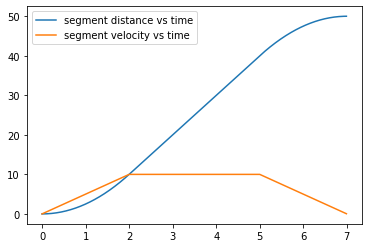

In [58]:
my_move = Move(0, 0.0, (0.0, 0.0), (50, 0.0))
time_series = np.arange(0, my_move.t_move_end, 0.01)
dist_series = [my_move.get_position(t) for t in time_series]
velocity_series = [my_move.get_velocity(t) for t in time_series]
plt.plot(time_series, dist_series, label = "segment distance vs time")
plt.plot(time_series, velocity_series, label = "segment velocity vs time")
plt.legend()
plt.show()

# Time from Position.
Let's try to reproduce the same graph of $x(t)$ above by computing the function inverse.

seed guess: 0.5


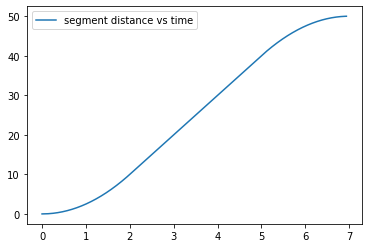

In [57]:
# Recalculate the position curve above by computing the function inverse.
dist_series = np.arange(0, 50, 0.01)
time_series = []
for index in range(len(dist_series)):
    # Use the previous time as a guess to seed the next answer.
    # Avoid cases where any guess would produce division-by-zero (v(guess) = 0)
    if np.allclose(dist_series[index], 0) or np.allclose(dist_series[index-1], 0):
        time_series.append(my_move.get_time_at_pos_newton(dist_series[index]))
        continue
    time_series.append(my_move.get_time_at_pos_newton(dist_series[index], time_series[index - 1]))

plt.plot(time_series, dist_series, label = "segment distance vs time")
plt.legend()
plt.show()

# References

### Input Shaping
* [Underdamped Harmonic Oscillator Eqns](https://rotorlab.tamu.edu/me617/ME617_Examples_1DOF_transient_response.pdf)
* [Input Shaping Tutorial](http://code.eng.buffalo.edu/tdf/papers/acc_tut.pdf)
* [Control of Gantry Crane Using Input Shaping Schemes with Distributed Delay](https://core.ac.uk/download/pdf/322385879.pdf)
* [Input Shaping Design for Flexible Systems with Multiple Actuators](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.49.4930&rep=rep1&type=pdf)


### Motion Control
* [GRBL Motion Planner Source Code](https://github.com/grbl/grbl/blob/master/grbl/planner.c)
* [Klipper Kinematics](https://github.com/KevinOConnor/klipper/blob/master/docs/Kinematics.md)


### Math
* [1D Kinematics Formulas for constant Acceleration](https://www.khanacademy.org/science/physics/one-dimensional-motion/kinematic-formulas/a/what-are-the-kinematic-formulas)
* [Root Solving with Newton's Method](https://en.wikipedia.org/wiki/Newton%27s_method#Description)
* [Exponential Fitting with Python](https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly) (unused)
